In [1]:
from simulation_core import *
import simpy
import matplotlib.pyplot as plt

## What do i want from this simulation?

- Experiment with the concept of SMART DRIVER

In [ ]:
# Gaussian distribution parameters
TRAVEL_TIME_MEAN = 15
TRAVEL_TIME_STD = 2

BUS_CAPACITY = 25  # Amount of passengers that each bus can carry
MAX_PASSENGERS = 500  # Maximum number of passengers that can be generated in the simulation
BASE_LAMBDA = 1 # Regulates the average arrival rate of passengers (1/lambda is the average time between arrivals)
SIMULATION_TIME = 240
PEAK_HOUR = 150  # Time in minutes when the peak hour starts (e.g., 150 minutes = 2 hours and 30 minutes)
PEAK_FACTOR = 5 # Factor by which the arrival rate increases during the peak hour
SMART_PERCENTAGE = 0.5  # Percentage of bus capacity that must be filled before the bus departs
SMART_TIME = 10  # Time the bus can wait before deciding to leave
SMART_DRIVER = True # Indicates if the bus driver is smart (True) or not (False)
TOTAL_BUSES = 4 # Total number of buses in the simulation
VERBOSE = False  # If True, prints detailed logs during the simulation

smart_driver = [True]
bus_amount  = [3]
smart_percentage = [0.8]
smart_time = [10]
smart_last_boarding_time = [2]
configurations = []

# Execute simulations for different configurations of buses and smart drivers parameters
for SMART_PERCENTAGE in smart_percentage :
    for SMART_TIME in smart_time:
        for NUM_NAVETTE_TOTALI in bus_amount :
            for SMART_DRIVER in smart_driver:
                for SMART_LAST_BOARDING_TIME in smart_last_boarding_time:
                    # Create a configuration for each combination of parameters
                    configuration = Configuration(NUM_NAVETTE_TOTALI, SMART_DRIVER, SMART_TIME, SMART_PERCENTAGE, SMART_LAST_BOARDING_TIME, MAX_PASSENGERS)
                    for i in range(500):

                        env = simpy.Environment()

                        # Passenger queue
                        passenger_queue = simpy.Store(env)

                        # This Store manages which bus is ACTIVE for boarding at any given moment
                        # It has a capacity of 1, so only ONE bus can be placed here at a time.
                        # Buses "compete" to be here.
                        bus_attivi_per_imbarco = simpy.Store(env, capacity=1)

                        # Start the bus processes
                        for i in range(NUM_NAVETTE_TOTALI):
                            navetta_obj = Bus(env, f'Bus_{i+1}', BUS_CAPACITY)
                            env.process(bus_process(env, navetta_obj, bus_attivi_per_imbarco, passenger_queue,
                                                            SMART_DRIVER= SMART_DRIVER,
                                                                SMART_TIME=SMART_TIME,
                                                                    SMART_PERCENTAGE=SMART_PERCENTAGE,
                                                                        TRAVEL_TIME_MEAN=TRAVEL_TIME_MEAN,
                                                                            TRAVEL_TIME_STD=TRAVEL_TIME_STD))

                        # Start the passenger generator
                        history = []  # List to keep track of passengers for the final report
                        env.process(participant_generator(env, passenger_queue, history,
                                                        tempo_massimo_simulazione=SIMULATION_TIME,
                                                            MAX_PASSENGERS=MAX_PASSENGERS,
                                                                PEAK_HOUR=PEAK_HOUR,
                                                                    BASE_LAMBDA=BASE_LAMBDA,
                                                                        PEAK_FACTOR=PEAK_FACTOR))

                        # Execute the simulation
                        if VERBOSE:
                            print(f'--- Simulation started for {SIMULATION_TIME} minutes ---')
                        env.run(until=SIMULATION_TIME)
                        if VERBOSE:
                            print('--- Simulation end ---')

                        configuration.history.append(history)  # Save the passenger history in the configuration
                    configurations.append(configuration)

In [3]:
average_waiting_times = []
for config in configurations:
    print(f'Configurazione: {config.num_navette} navette, Smart Driver: {config.smart_driver}, Smart Time: {config.smart_time}, Smart Percentage: {config.smart_percentage}')
    total_passengers = sum(len(history) for history in config.history)
    print(f'Totale passeggeri imbarcati: {total_passengers}')
    average_waiting_times.append(sum(p.time_departure - p.time_arrival for history in config.history for p in history if p.time_departure is not None) / total_passengers)
    print(f'Tempo medio di attesa per i passeggeri: {average_waiting_times[-1]:.2f} minuti')

Configurazione: 3 navette, Smart Driver: True, Smart Time: 10, Smart Percentage: 0.8
Totale passeggeri imbarcati: 250000
Tempo medio di attesa per i passeggeri: 4.09 minuti


(array([1.392e+03, 6.510e+02, 6.800e+02, 7.450e+02, 7.910e+02, 8.190e+02,
        8.430e+02, 8.740e+02, 8.380e+02, 9.640e+02, 9.100e+02, 9.680e+02,
        9.540e+02, 9.450e+02, 9.860e+02, 9.380e+02, 9.380e+02, 8.740e+02,
        8.750e+02, 7.710e+02, 7.430e+02, 6.680e+02, 6.310e+02, 5.740e+02,
        5.130e+02, 4.170e+02, 3.750e+02, 3.580e+02, 3.140e+02, 3.220e+02,
        2.800e+02, 2.900e+02, 2.270e+02, 1.960e+02, 1.910e+02, 1.560e+02,
        8.500e+01, 6.800e+01, 5.400e+01, 4.000e+01, 2.800e+01, 1.600e+01,
        1.300e+01, 1.200e+01, 5.000e+00, 6.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00]),
 array([ 0.        ,  0.28715099,  0.57430198,  0.86145297,  1.14860396,
         1.43575495,  1.72290594,  2.01005693,  2.29720792,  2.58435891,
         2.8715099 ,  3.15866089,  3.44581188,  3.73296287,  4.02011386,
         4.30726485,  4.59441584,  4.88156683,  5.16871782,  5.45586881,
         5.7430198 ,  6.03017079,  6.31732178,  6.60447277,  6.89162376,
         7.

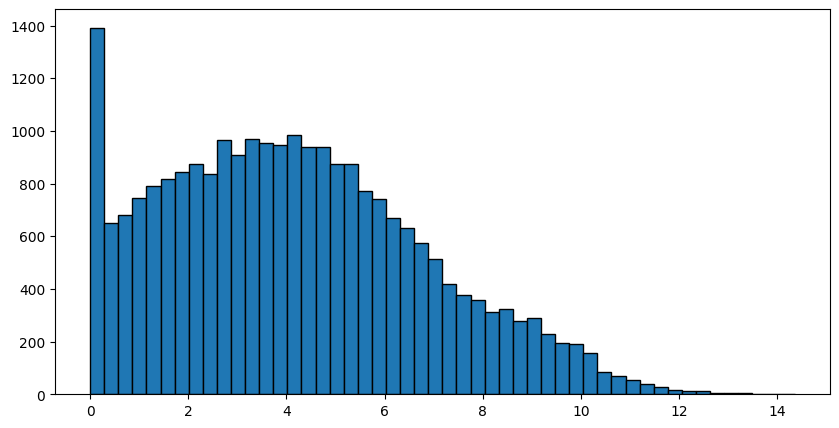

In [ ]:
# plot distribution of waiting times for a specific configuration
plt.figure(figsize=(10, 5))
waiting_times = [p.time_departure - p.time_arrival for history in configurations[0].history for p in history if p.time_departure is not None]
plt.hist(waiting_times, bins=50, edgecolor='black')

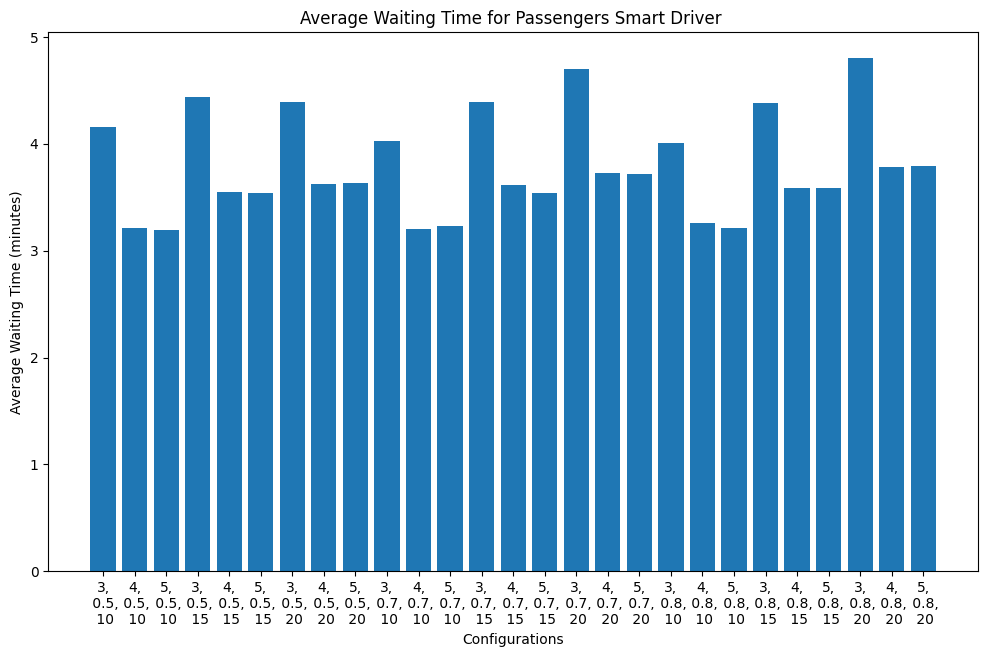

In [9]:
# plot the average waiting times for each configuration where smart driver is True 

filtered_times = [t for i, t in enumerate(average_waiting_times) if configurations[i].smart_driver]
filtered_labels = [f'{configurations[i].num_navette},\n {configurations[i].smart_percentage},\n {configurations[i].smart_time}' for i in range(len(average_waiting_times)) if configurations[i].smart_driver]

# Plotta solo quelle
plt.figure(figsize=(12, 7))
plt.bar(range(len(filtered_times)), filtered_times, tick_label=filtered_labels)
plt.xlabel('Configurations')
plt.ylabel('Average Waiting Time (minutes)')
plt.title('Average Waiting Time for Passengers Smart Driver ')
plt.show()


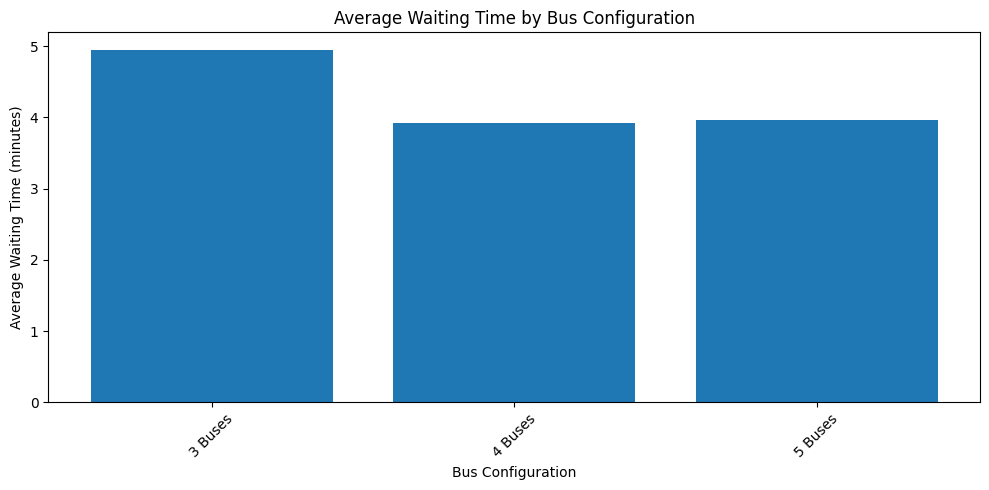

In [8]:
# Plot the average waiting times for each configuration
plt.figure(figsize=(10, 5))
plt.bar([f'{config.num_navette} Buses' for config in configurations], average_waiting_times)
plt.xlabel('Bus Configuration')
plt.ylabel('Average Waiting Time (minutes)')
plt.title('Average Waiting Time by Bus Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# print maximum waiting time for each configuration and the arrival time of the maximum waiting time
print("\nmaximum waiting time for each configuration:")
for config in configurations:
    for history in config.history:
        curren_max = None
        for p in history:
            if p.time_departure is not None:
                waiting_time = p.time_departure - p.time_arrival
                if curren_max is None or waiting_time > curren_max[0]:
                    curren_max = (waiting_time, p.time_arrival, config.num_navette, config.smart_driver, config.smart_time, config.smart_percentage)
        print(f'maximum waiting time: {curren_max[0]:.2f} minutes, arrival time: {curren_max[1]:.2f} minutes, configuration: {curren_max[2]} buses, smart driver: {curren_max[3]}, smart time: {curren_max[4]}, smart percentage: {curren_max[5]}')



maximum waiting time for each configuration:
maximum waiting time: 18.18 minutes, arrival time: 30.44 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 22.34 minutes, arrival time: 1.15 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 20.52 minutes, arrival time: 0.18 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 16.57 minutes, arrival time: 46.07 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 18.51 minutes, arrival time: 15.81 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 18.95 minutes, arrival time: 39.36 minutes, configuration: 3 buses, smart driver: True, smart time: 10, smart percentage: 0.5
maximum waiting time: 18.67 minutes, arrival time: 10.43 minutes, co

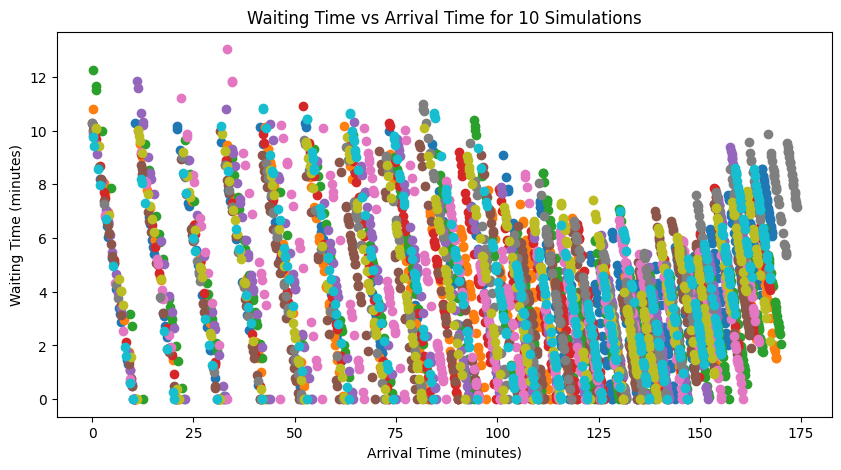

In [5]:
# plot the waiting times of 10 simulatrions on y axis and the arrival times on x axis
plt.figure(figsize=(10, 5))
for i, history in enumerate(configurations[0].history[:10]):  # Prendi le prime 10 simulazioni
    arrival_times = [p.time_arrival for p in history if p.time_departure is not None]
    waiting_times = [p.time_departure - p.time_arrival for p in history if p.time_departure is not None]
    plt.plot(arrival_times, waiting_times, marker='o', linestyle='')
plt.xlabel('Arrival Time (minutes)')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time vs Arrival Time for 10 Simulations')
plt.show()